In [2]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
import matplotlib.animation as animation

nu = 0.01

# Load data and create training dataset
data = scipy.io.loadmat('cylinder_wake.mat')

U_star = data['U_star']  # N x 2 x T
P_star = data['p_star']  # N x T
t_star = data['t']  # T x 1
X_star = data['X_star']  # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

# Rearrange Data
XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
TT = np.tile(t_star, (1, N)).T  # N x T

UU = U_star[:, 0, :]  # N x T
VV = U_star[:, 1, :]  # N x T
PP = P_star  # N x T

x = XX.flatten()[:, None]  # NT x 1
y = YY.flatten()[:, None]  # NT x 1
t = TT.flatten()[:, None]  # NT x 1

u = UU.flatten()[:, None]  # NT x 1
v = VV.flatten()[:, None]  # NT x 1
p = PP.flatten()[:, None]  # NT x 1

# Randomly sample data without using N_train
idx = np.random.choice(N * T, 5000, replace=False)
x_train = torch.tensor(x[idx, :], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idx, :], dtype=torch.float32, requires_grad=True)
t_train = torch.tensor(t[idx, :], dtype=torch.float32, requires_grad=True)
u_train = torch.tensor(u[idx, :], dtype=torch.float32)
v_train = torch.tensor(v[idx, :], dtype=torch.float32)
p_train = torch.tensor(p[idx, :], dtype=torch.float32)

# Define a simple ResNet block
class ResNetBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResNetBlock, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = nn.Tanh()
    
    def forward(self, x):
        return self.activation(self.linear(x)) + x

# Define the ResNet-style neural network with 7 hidden layers
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.input_layer = nn.Linear(3, 20)
        self.res_block1 = ResNetBlock(20, 20)
        self.res_block2 = ResNetBlock(20, 20)
        self.res_block3 = ResNetBlock(20, 20)
        self.res_block4 = ResNetBlock(20, 20)
        self.res_block5 = ResNetBlock(20, 20)
        self.res_block6 = ResNetBlock(20, 20)
        self.res_block7 = ResNetBlock(20, 20)
        self.output_layer = nn.Linear(20, 3)
        self.activation = nn.Tanh()
    
    def forward(self, x):
        x = self.activation(self.input_layer(x))
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)
        x = self.res_block5(x)
        x = self.res_block6(x)
        x = self.res_block7(x)
        x = self.output_layer(x)
        return x

net = ResNet()

# Define the loss function and optimizer
mse = nn.MSELoss()

def create_pde(x, y, t):
    res = net(torch.hstack((x, y, t)))
    psi, p = res[:, 0:1], res[:, 1:2]

    u = torch.autograd.grad(psi, y, grad_outputs=torch.ones_like(psi), create_graph=True)[0]  
    v = -1. * torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
    v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

    f = u_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
    g = v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)

    return u, v, p, f, g

# Train the model using LBFGS
optimizer_lbfgs = torch.optim.LBFGS(net.parameters(), lr=1, max_iter=20000, max_eval=50000,
                                    history_size=50, tolerance_grad=1e-05, tolerance_change=0.5 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")

loss_history = []
f_residual_history = []
g_residual_history = []
lbfgs_iter = 0  # Initialize the LBFGS iteration counter

# Fine-tuning with LBFGS
def closure():
    global lbfgs_iter  # Access the global iteration variable
    optimizer_lbfgs.zero_grad()

    u_prediction, v_prediction, p_prediction, f_prediction, g_prediction = create_pde(x_train, y_train, t_train)
    u_loss = mse(u_prediction, u_train)
    v_loss = mse(v_prediction, v_train)
    p_loss = mse(p_prediction, p_train)
    f_loss = mse(f_prediction, torch.zeros_like(f_prediction))
    g_loss = mse(g_prediction, torch.zeros_like(g_prediction))

    loss = u_loss + v_loss + p_loss + f_loss + g_loss
    loss.backward()

    # Save the current loss and residuals
    loss_history.append(loss.item())
    f_residual_history.append(f_loss.item())
    g_residual_history.append(g_loss.item())

    # Print the current iteration and loss
    lbfgs_iter += 1
    if lbfgs_iter % 10 == 0:
        print(f'LBFGS Iteration {lbfgs_iter}, Loss: {loss.item()}')

    return loss

optimizer_lbfgs.step(closure)

# Save the trained model
torch.save(net.state_dict(), 'pinn_pretrained_resnet.pt')

# Plot the loss and residual curves
plt.figure()
plt.plot(loss_history, label='Total Loss')
plt.plot(f_residual_history, label='f Residual')
plt.plot(g_residual_history, label='g Residual')
plt.xlabel('Iteration')
plt.ylabel('Loss / Residual')
plt.title('Loss and Residual Curves')
plt.legend()
plt.show()

# Load the trained model and evaluate
net.eval()

x_test = torch.tensor(X_star[:, 0:1], dtype=torch.float32, requires_grad=True)
y_test = torch.tensor(X_star[:, 1:2], dtype=torch.float32, requires_grad=True)
t_test = torch.tensor(np.ones((X_star.shape[0], 1)), dtype=torch.float32, requires_grad=True)

u_out, v_out, p_out, f_out, g_out = create_pde(x_test, y_test, t_test)


LBFGS Iteration 10, Loss: 0.32137662172317505
LBFGS Iteration 20, Loss: 0.20127379894256592
LBFGS Iteration 30, Loss: 0.16974163055419922
LBFGS Iteration 40, Loss: 0.15765281021595
LBFGS Iteration 50, Loss: 0.14132314920425415
LBFGS Iteration 60, Loss: 0.1297283172607422
LBFGS Iteration 70, Loss: 0.11849505454301834
LBFGS Iteration 80, Loss: 0.11046338081359863
LBFGS Iteration 90, Loss: 0.10655761510133743
LBFGS Iteration 100, Loss: 0.10440125316381454
LBFGS Iteration 110, Loss: 0.10341628640890121
LBFGS Iteration 120, Loss: 0.10263217240571976
LBFGS Iteration 130, Loss: 0.10220292210578918
LBFGS Iteration 140, Loss: 0.10182403028011322
LBFGS Iteration 150, Loss: 0.10150990635156631
LBFGS Iteration 160, Loss: 0.101255863904953
LBFGS Iteration 170, Loss: 0.10109429061412811
LBFGS Iteration 180, Loss: 0.10100055485963821
LBFGS Iteration 190, Loss: 0.10080458968877792
LBFGS Iteration 200, Loss: 0.10089746862649918
LBFGS Iteration 210, Loss: 0.10063480585813522
LBFGS Iteration 220, Loss: 0

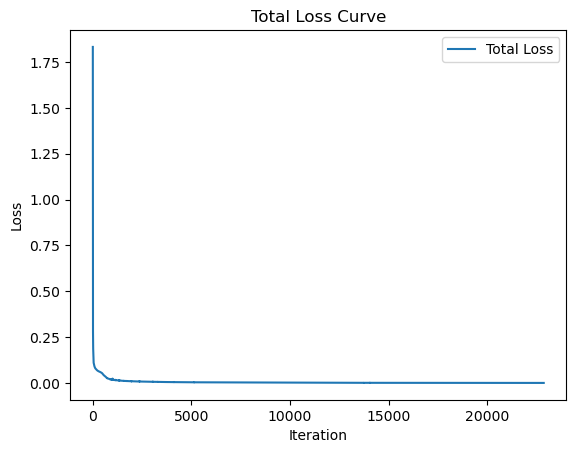

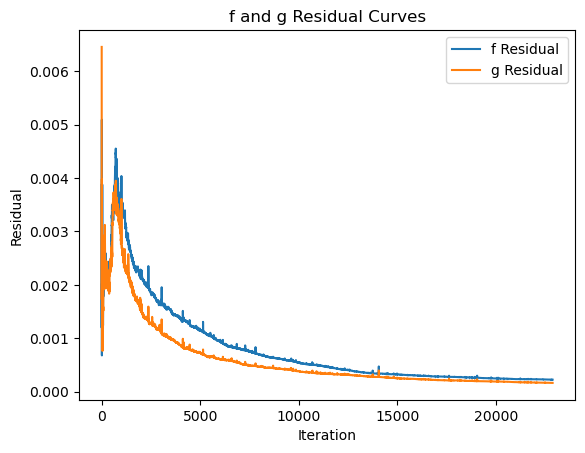

In [ ]:
import matplotlib.pyplot as plt

# Assuming loss_history, f_residual_history, and g_residual_history are available from the training process

# Plotting the total loss in one plot
plt.figure()
plt.plot(loss_history, label='Total Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Total Loss Curve')
plt.legend()
plt.show()

# Plotting f and g residuals in another plot
plt.figure()
plt.plot(f_residual_history, label='f Residual')
plt.plot(g_residual_history, label='g Residual')
plt.xlabel('Iteration')
plt.ylabel('Residual')
plt.title('f and g Residual Curves')
plt.legend()
plt.show()

